Generating instances of minimum dominating set and minimum connected dominating set, as well as exploring the corresponding Gröbner basis.

In [1]:
using GLPK
using Graphs
using GraphMaki
using CairoMakie
using IPGBs
using JuMP
using Random

The paper "Lucena et al - Reformulations and solution algorithms to the maximum leaf spanning tree problem" proposes the following simple way to generate random instances for the minimum connected dominating set problem.

In [2]:
function generate_graph(n :: Int, density :: Float64)
    g = Graph(n)
    #Start by generating a random Hamiltonian path (guarantees connectivity)
    vertices = collect(1:n)
    randperm!(vertices)
    for i in 1:(n-1)
        add_edge!(g, vertices[i], vertices[i+1])
    end
    max_edges = n*(n-1)/2
    current_edges = n-1
    current_density = (n-1)/max_edges
    if current_density >= density
        return g
    end
    #Now add edges randomly to reach the desired density
    #Use space instead of running time: generate all O(n^2) possible edges and shuffle them
    all_edges = [(i,j) for i in 1:n for j in 1:(i-1)]
    shuffle!(all_edges)
    i = 1
    while current_density < density
        u, v = all_edges[i]
        i += 1
        if has_edge(g, u, v)
            continue
        end
        add_edge!(g, u, v)
        current_edges += 1
        current_density = current_edges/max_edges
    end
    return g
end

generate_graph (generic function with 1 method)

Now I'll generate some small example graphs and compute their Gröbner bases.

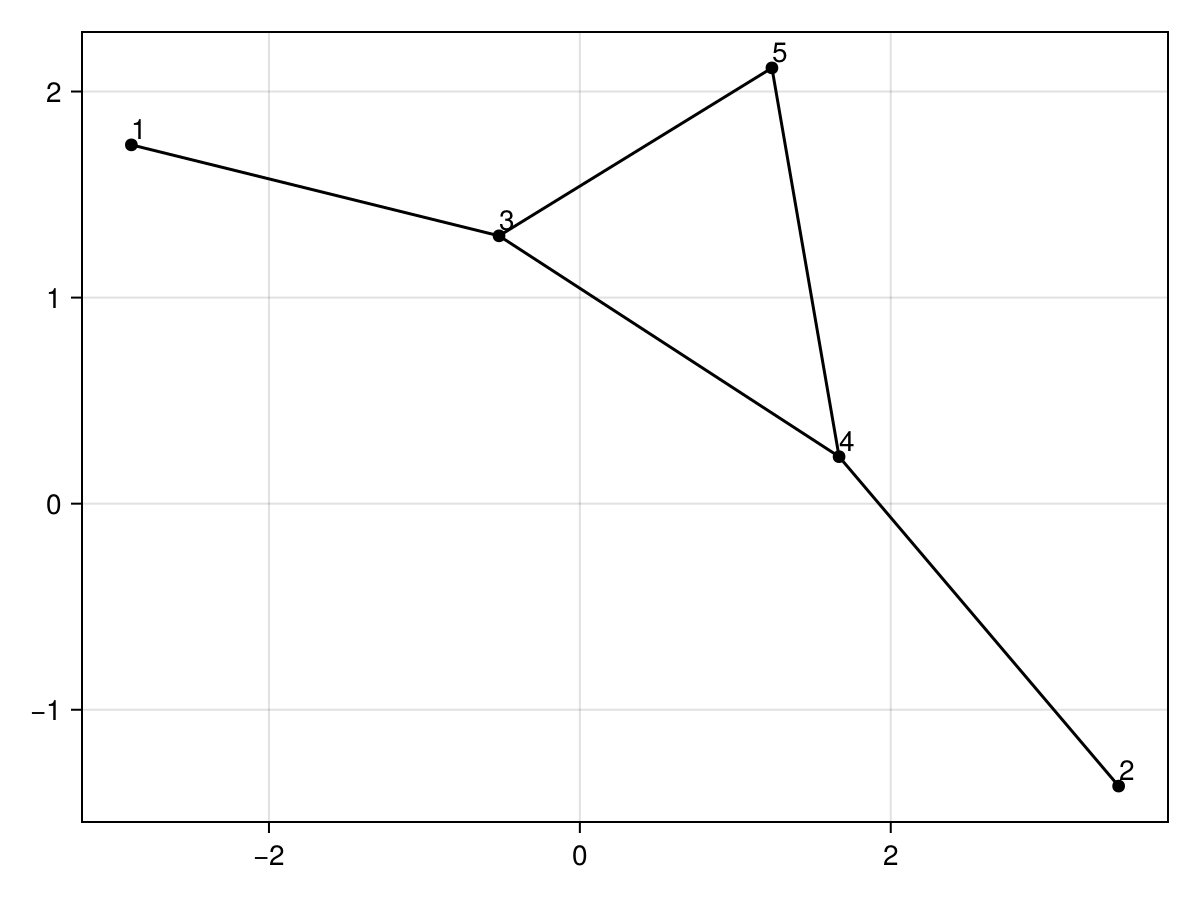

In [3]:
g1 = generate_graph(5, 0.5)
graphplot(g1, nlabels=[string(i) for i in 1:nv(g1)])

In [4]:
function dominating_set_model(g :: Graph)
    n = nv(g)
    model = Model()
    @variable(model, x[1:n], Bin)
    @objective(model, Min, sum(x))
    for v in 1:n
        ns = neighbors(g, v)
        @constraint(model, x[v] + sum(x[ns]) >= 1)
    end
    return model
end

dominating_set_model (generic function with 1 method)

In [5]:
gb = IPGBs.groebner_basis(dominating_set_model(g1))
println("GB elements: ", length(gb))
for g in gb
    println(g[1:nv(g1)])
end

┌ Info: P&L bounded case
│   i = 11
│   length(pl.markov) = 5
└ @ IPGBs.Markov /home/gmlangeloh/.julia/dev/IPGBs/src/Markov.jl:343


GB elements: 19
[-1, 0, 0, 0, 1]
[-1, 0, 0, 1, 0]
[-1, 0, 1, 0, 0]
[-1, 1, 1, -1, 0]
[0, -1, 0, 0, 1]
[0, -1, 0, 1, 0]
[0, -1, 1, 0, 0]
[0, 0, -1, 0, 1]
[0, 0, -1, 1, 0]
[0, 0, 0, -1, 1]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 1, 0, 0]
[0, 1, 0, 0, 0]
[0, 1, 1, -1, 0]
[1, 0, 0, 0, 0]
[1, 1, -1, 0, 0]
[1, 1, 0, -1, 0]
[1, 1, 0, 0, -1]


In [6]:
#Trying out slightly larger graphs, fixed density
Random.seed!(0)
for n in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    g = generate_graph(n, 0.5)
    gb = IPGBs.groebner_basis(dominating_set_model(g))
    println(n, " ", length(gb))
end

5 18
6 39
7 55
8 93
9 124
10 387
11 786
12 1632
13 2655
14 3464
15 6481


In [7]:
Random.seed!(0)
for n in [5, 10, 15]
    for d in [0.05, 0.1, 0.25, 0.5, 0.7]
        g = generate_graph(n, d)
        gb = IPGBs.groebner_basis(dominating_set_model(g))
        println(n, " ", d, " ", length(gb))
    end
    println()
end

5 0.05 16
5 0.1 17
5 0.25 14
5 0.5 24
5 0.7 22

10 0.05 96
10 0.1 71
10 0.25 145
10 0.5 271
10 0.7 254

15 0.05 189
15 0.1 442
15 0.25 2665
15 0.5 17365
15 0.7 5898



Conclusion: GBs mostly get larger as density goes up.

Now I'll try slightly larger instances with small density.

In [8]:
Random.seed!(0)
for n in [20, 25, 30]
    g = generate_graph(n, 0.05)
    gb, t, _, _, _ = @timed IPGBs.groebner_basis(dominating_set_model(g))
    println(n, " ", t, " ", length(gb))
    flush(stdout)
end

20 0.058300282 433
25 0.19250755 1531
30 201.989962444 68068


Next, I'll explore what happens when I use upper bounds on the size of the dominating set, starting from the trivial upper bounds and then
progressively lowering it. Instances with n = 25 should be large enough to see some effect.

In [12]:
#Generate reasonably sized instance
Random.seed!(0)
n = 25
g = generate_graph(n, 0.05)
model = dominating_set_model(g)

#Find optimal value and relaxation value
set_optimizer(model, GLPK.Optimizer)
set_silent(model)
optimize!(model)
best_value = round(Int, objective_value(model))

lp_model, _ = copy_model(model)
set_optimizer(lp_model, GLPK.Optimizer)
set_silent(lp_model)
relax_integrality(lp_model)
optimize!(lp_model)
lp_value = objective_value(lp_model)

#Compute GBs and compare sizes and timings
gb, t, _, _, _ = @timed IPGBs.groebner_basis(model)
println("OPT: ", best_value)
println("LP: ", lp_value)
println("NO_UB ", t, " ", length(gb))
upper_bound = @constraint(model, sum(model[:x]) <= n)
for ub in n:-1:best_value #9 is the optimal value
    set_normalized_rhs(upper_bound, ub)
    gb, t, _, _, _ = @timed IPGBs.groebner_basis(model)
    println(ub, " ", t, " ", length(gb))
    flush(stdout)
end

OPT: 9
LP: 9.0
NO_UB 1.415044277 7263
25 5.293381921 7263
24 5.355186251 7263
23 5.524195945 7263
22 5.473178804 7263
21 5.533108972 7263
20 5.622922767 7263
19 5.569121181 7263
18 5.509400336 7263
17 5.592841437 7263
16 5.60616126 7263
15 5.798882572 7263
14 5.590697503 7263
13 5.687088428 7184
12 5.422358752 5919
11 4.299551238 2919
10 2.421884377 505
9 1.346068915 42


Conclusion: in the current implementation, no upper bound is far faster until the upper bound starts getting close to the optimal value. Starting from lower bounds may be worthwhile in these kinds of covering problems though.